# Clustering with PCA [40 points]

In this applied question, you are asked to use Principal Component Analysis (PCA) for dimensionality reduction and then apply K-means clustering and Gaussian Mixture Model (GMM). You will use handwritten dataset from sklearn library.

Let's start by loading the data:

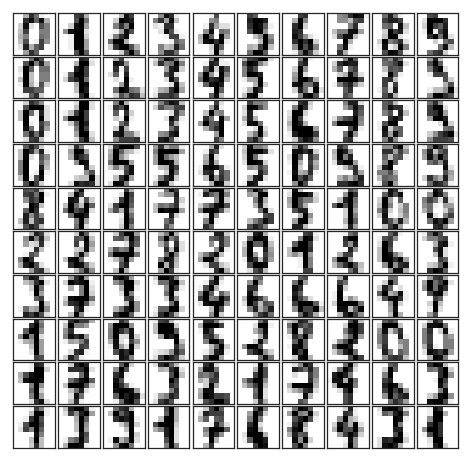

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True)

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## PCA (15 points)

To gain intuition on the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [4]:
# Import PCA
from sklearn.decomposition import PCA

## project from 64 to 2 dimensions using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(digits.data)

print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


### Visualize the projected data

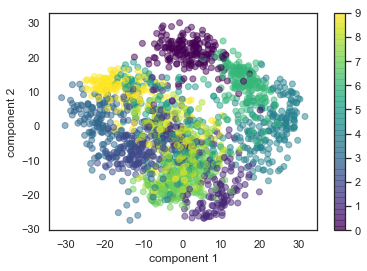

In [5]:
## visualize projected data using scatter plot
y_axis_zeros = np.zeros(len(projected))
plt.scatter(projected[:, 0], projected[:,1], c=digits.target, alpha=.5, cmap='viridis')

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**Question:** Based on the scatter plot using first two principal components, can K-means clustering perfectly separate all the classes when only 2 principal components are used? Explain why in 1-2 sentences.

**Answer:** No, k-means cannot perfectly separate all classes with only 2 pcs, because many of the classes overlap/have non-linear boundaries, which is beyond k-mean's abilities. We will need more principal components.

### Choosing the number of components

To decide the number of components to keep, let's look at the cumulative explained variance ratio as a function of the number of components.

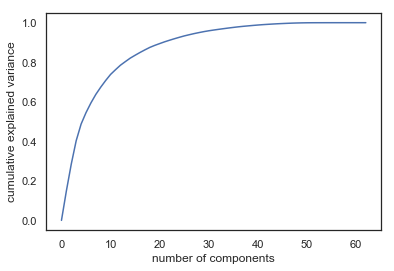

In [18]:
## obtain all the components and plot the cumulative explained variance with respect to the number of components

cumulative = []
for i in range(63):
    pca = PCA(n_components = i)
    projected = pca.fit_transform(digits.data)
    cume = np.sum(pca.explained_variance_ratio_)
    cumulative.append(cume)

plt.plot(cumulative, )
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

**Question:** How many components are needed to contain approximately 90% of the variance? And how many to describe close to 100% of the variance?

**Answer:** To get 90% of the variance, we would need about 22 components. To get close to 100%, we would need closer to 50 components.

Use the number of components to keep approximately 90% of the variance to reduce the dimension of the our data.

In [23]:
pca = PCA(n_components = 22)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 22)


## K-means Clustering (10 points)

Let's use K-means clustering algorithm to group the data points into 10 different clusters:

In [25]:
from sklearn.cluster import KMeans

# Initiate and fit a K-means model to projected data
kmeans = KMeans(n_clusters=10, max_iter=100)
clusters = kmeans.fit_predict(projected)
kmeans.cluster_centers_.shape

(10, 22)

The cluster centers themselves are 10-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's **un-project** these cluster centers back to the original 64 dimensions using inverse_transform of PCA and see what these cluster centers look like:

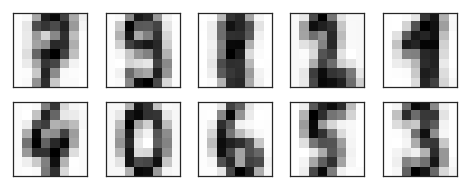

In [28]:
# unproject the cluster centers in reduced dimension back to original dimension. Hint: use inverse_transform in PCA
cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Can you visually label each of these un-projected cluster centers? If yes, please give a digit label for each of the cluster centers?

**Answer:** Yes: 7, 9, 8 (vaguely), 2, 1, 4, 0, 5, 3

By default, the number of times the K-means algorithm will be run with different centroid **seeds** is 10. The final result will be the best output of n_init consecutive runs in terms of inertia. Let's increase this number to 100 and compare the results.

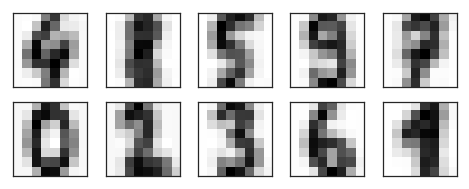

In [29]:
kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters = kmeans.fit_predict(projected)

cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Do the cluster centers look similar or different from those returned using only 10 runs?

**Answer:** The cluster centers are in a different order, but look very similar.

### Measure accuracy of K-means clustering

Because K-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them.

In [32]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7941012799109627

## Compare K-means and Gaussian Mixture Models (Expectation Maximization) (10 points)

For visualization purposes, let's use first two principal components only in the PCA and compare the results of K-means and GMM.

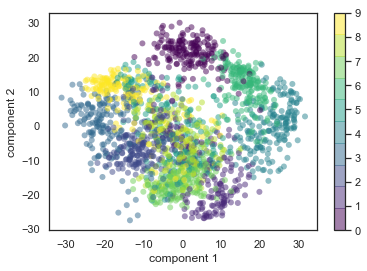

In [35]:
pca = PCA(n_components = 2)
projected = pca.fit_transform(digits.data)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

0.6093489148580968

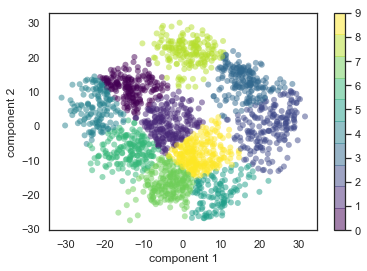

In [38]:
## train a K-means model on projected data, plots the clusters and measure the accuracy

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters = kmeans.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

0.6366165831942125

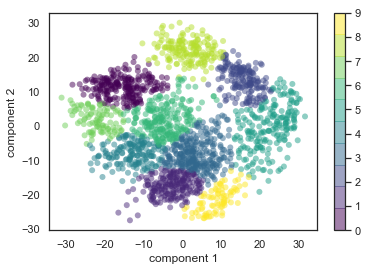

In [40]:
# train and plot GMM

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 10, n_init = 100)
clusters = gmm.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=clusters, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

**Question:** Compare the accuracy of K-means and GMM? Can you spot the differences that explain the comparison results in the plots of K-means and GMM clusters?

**Answer:** GMM does roughly 3 percentage points better than k-means in terms of accuracy. GMM allows for some overlap of clusters (in contrast to the strict boundaries seen in the k-means cluster diagram), which explains GMM's improved accuracy. GMM's boundaries also appear smoother, allowing for more flexibility in cluster assignment and thus an increase in accuracy.

## t-SNE for dimensionality reduction (5 points)

Let's try t-SNE to reduce the original data dimension to 2 and then use K-means to cluster it.

0.9426822481914302

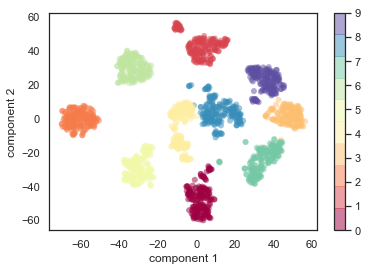

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
projected = tsne.fit_transform(digits.data)

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters = kmeans.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

**Question:** Compare the accuracy resulted from K-means with t-SNE (n_components = 2) with that of K-means with PCA (n_components = 20) and justify your observation (why)?

**Answer:** T-SNE achieved a 94.3% accuracy compared to only 60.9% with k-means with PCA. This is because PCA breaks down when the data can not be linearly separated in higher dimensions.